# Permutation Test

In [1]:
%run setup.py

In [2]:
df_Invited = pd.read_csv(os.path.join(filepath,'factInvited.csv'))
df_Proceedings = pd.read_csv(os.path.join(filepath,'factProceedings.csv'))

df_Invited.head()

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,Paper Count,Max Paper Count,First year paper,Age,Conference (long),Main Topic,Productivity
0,Alex Sandy Pentland,2004,AAAI,Alex,Sandy,Pentland,M,206,425,1982,22,AAAI Conference on Artificial Intelligence,Artificial Intelligence,9.363636
1,Astro Teller,2004,AAAI,Astro,NaN,Teller,M,8,8,1994,10,AAAI Conference on Artificial Intelligence,Artificial Intelligence,0.800000
2,Daniel J. Clancy,2004,AAAI,Daniel,J.,Clancy,M,8,9,1996,8,AAAI Conference on Artificial Intelligence,Artificial Intelligence,1.000000
3,Edward Feigenbaum,2004,AAAI,Edward,NaN,Feigenbaum,M,39,44,1961,43,AAAI Conference on Artificial Intelligence,Artificial Intelligence,0.906977
4,Ian Lane Davis,2004,AAAI,Ian,Lane,Davis,M,1,3,1995,9,AAAI Conference on Artificial Intelligence,Artificial Intelligence,0.111111


## Define functions

In [3]:
def Permutation_test(df,n,column): 
    # Drop all rows with 0 values
    df = df[df[column] != 0]

    # Save the true values
    True_avg_F = df.groupby('gender')[column].mean()[0] # female
    True_avg_M = df.groupby('gender')[column].mean()[1] # male
    True_delta = True_avg_F - True_avg_M
    
    # initialize the lists to store the averages
    avg_F = []
    avg_M = []

    prop_F = df['gender'].value_counts( normalize=True).loc['F']
    prop_M = df['gender'].value_counts( normalize=True).loc['M']

    for i in range(n):
        # randomly assign a new gender to each row
        df['gender'] = np.random.choice(['F', 'M'], size=len(df), p=[prop_F, prop_M])
        
        # Insert a control check
        while len(df.groupby('gender').count()) < 2:
            df['gender'] = np.random.choice(['F', 'M'], size=len(df), p=[prop_F, prop_M])

        # calculate and store the average value for each gender
        avg_F.append(df.groupby('gender')[column].mean()[0]) # female
        avg_M.append(df.groupby('gender')[column].mean()[1]) # male
        
    delta = [x - y for x, y in zip(avg_F, avg_M)]
    
    return avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta

In [44]:
def Permutation_plot_delta(delta,True_delta, column,type,hight,width,image_name,image_path=image_path):
    # calculate the weights for the histograme
    weights_D = np.ones_like(delta) / len(delta)
    
    
    # Plot the distribution of the averages
    fig, ax2 = plt.subplots(1, 1, figsize=(width, hight))

    ###### Histogram of the simulated deltas ######
    # Plot histogram
    ax2.hist(delta, label="$\\bar{X}_F$ - $\\bar{X}_M$", alpha = 0.7, weights=weights_D, bins=40)
    # Plot line
    ax2.axvline(True_delta, color='dimgrey', linestyle='dashed', linewidth=2, label = "$\mu_F$ - $\mu_M$" + ": "+str(round(True_delta,2)))
    # Legend, title, labels
    ax2.legend( prop={'size': 15})
    ax2.set_title("Permutation test for " + type + " speakers on " + column, fontsize=18)
    ax2.set_xlabel("$\\bar{X}_F$ - $\\bar{X}_M$ " + column, fontsize=17)
    ax2.set_ylabel("Density", fontsize=17)
    ax2.tick_params(axis='both', labelsize=14)

    plt.tight_layout()
    plt.savefig(image_path+image_name,bbox_inches='tight')
    plt.show()

In [25]:
def Permutation_plot_F_M(avg_F,True_avg_F,avg_M,True_avg_M, column,type,hight,width,image_name,image_path=image_path):
    # calculate the weights for the histograme
    weights_F = np.ones_like(avg_F) / len(avg_F)
    weights_M = np.ones_like(avg_M) / len(avg_M)
    
    # calculate the bins for the histogram
    bins=np.histogram(np.hstack((avg_M,avg_F)), bins=40)[1]
    
    # Plot the distribution of the averages
    fig, ax2 = plt.subplots(1, 1, figsize=(width, hight))

    ###### Histogram of the simulated deltas ######
    # Plot histogram
    ax2.hist(avg_F, label="$\\bar{X}_F$", alpha = 0.7, weights=weights_F, bins=bins,color='C0')
    ax2.hist(avg_M, label="$\\bar{X}_M$", alpha = 0.7, weights=weights_M, bins=bins,color='C1')
    # Plot line
    ax2.axvline(True_avg_F, color='C0', linestyle='dashed', linewidth=2, label = "$\mu_F$" + ": "+str(round(True_avg_F,2)))
    ax2.axvline(True_avg_M, color='C1', linestyle='dashed', linewidth=2, label = "$\mu_M$" + ": "+str(round(True_avg_M,2)))
    # Legend, title, labels
    ax2.legend( prop={'size': 15})
    ax2.set_title("Permutation test for " + type + " speakers on " + column, fontsize=18)
    ax2.set_xlabel("$\\bar{X}$ " + column, fontsize=17)
    ax2.set_ylabel("Density", fontsize=17)
    ax2.tick_params(axis='both', labelsize=14)
    plt.tight_layout()
    plt.savefig(image_path+image_name,bbox_inches='tight')
    plt.show()

In [12]:
# avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta 
def p_test(delta, True_delta,tail):
    if tail == 'lower':
        print(len([x for x in delta if x < True_delta]))
        print("delta < True_delta")
        return len([x for x in delta if x < True_delta]) / len(delta)
    else:
        print(len([x for x in delta if x > True_delta]))
        print("delta > True_delta")
        return len([x for x in delta if x > True_delta]) / len(delta)

## Permutation test for Age, Paper Count, Productivity

In [13]:
# rename column in df_invited
df_Invited.rename(columns={'Age':'Seniority'}, inplace=True)
df_Invited.rename(columns={'Paper Count':'Cum. paper count'}, inplace=True)
df_Proceedings.rename(columns={'Age':'Seniority'}, inplace=True)
df_Proceedings.rename(columns={'Paper Count':'Cum. paper count'}, inplace=True)

### Age

In [42]:
avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta = Permutation_test(df_Invited,10000,'Seniority')

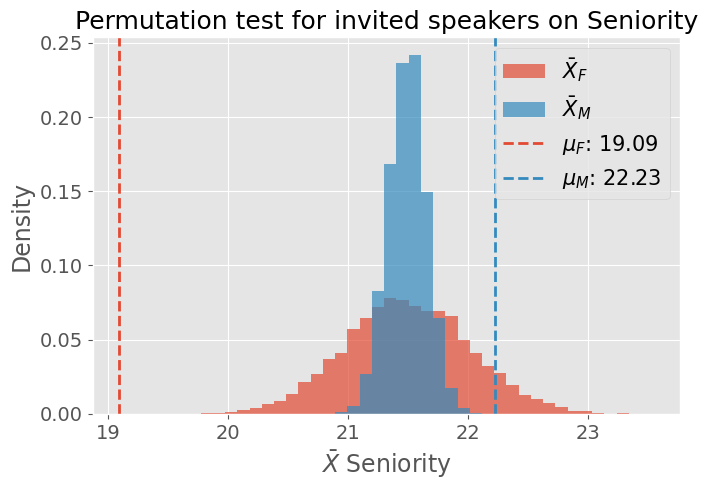

In [26]:
Permutation_plot_F_M(avg_F,True_avg_F,avg_M,True_avg_M, 'Seniority', 'invited', 5, 7,'Permu_age_F_M.pdf')

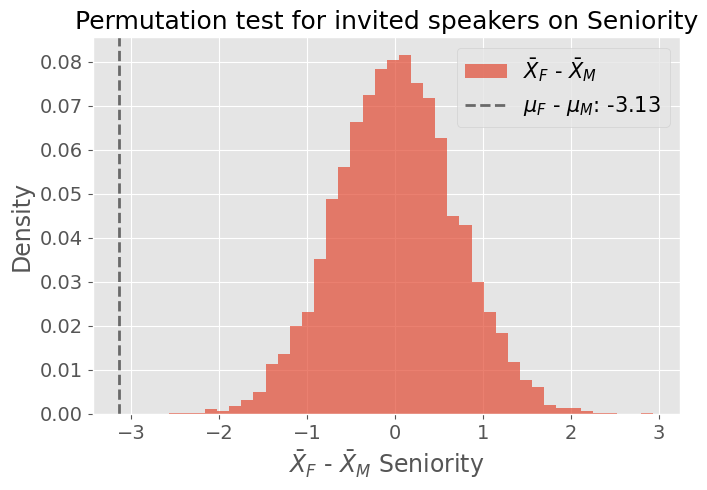

In [45]:
Permutation_plot_delta(delta, True_delta, 'Seniority', 'invited', 5, 7,'Permu_age_inv.pdf')

In [31]:
p_test(avg_M, True_avg_M,'lowerl')

1
delta > True_delta


0.0001

### Paper Count

In [46]:
avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta = Permutation_test(df_Invited,10000,'Cum. paper count')

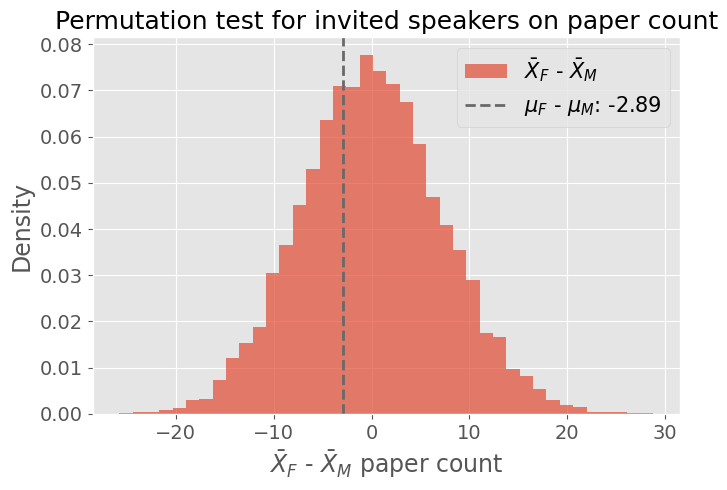

In [47]:
Permutation_plot_delta(delta, True_delta, 'paper count', 'invited', 5, 7,'Permu_paper_inv.pdf')

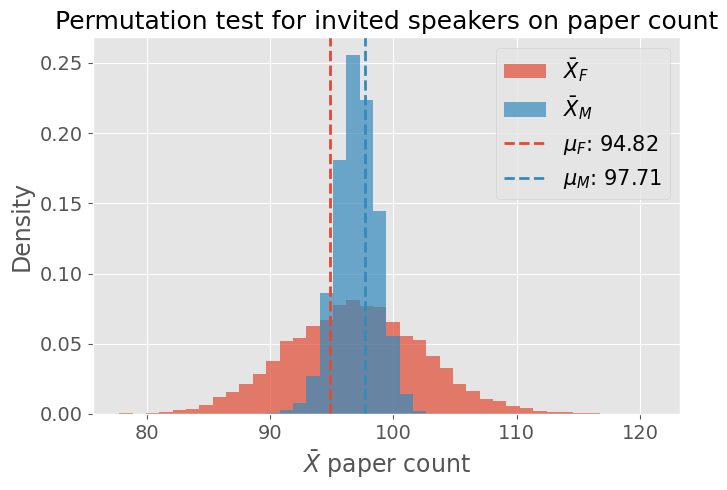

In [34]:
Permutation_plot_F_M(avg_F,True_avg_F,avg_M,True_avg_M, 'paper count', 'invited', 5, 7,'Permu_paper_F_M.pdf')

In [35]:
p_test(avg_F,True_avg_F,'lower')

3494
delta < True_delta


0.3494

In [48]:
avg_F, avg_M, delta, True_avg_F, True_avg_M, True_delta = Permutation_test(df_Invited,10000,'Productivity')

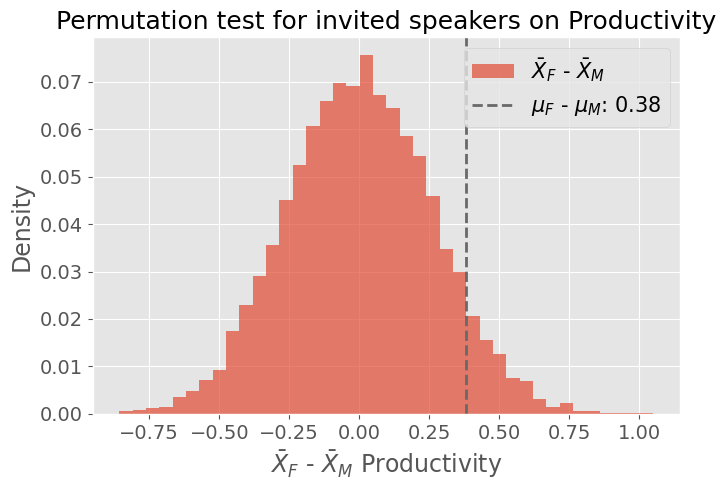

In [49]:
Permutation_plot_delta(delta, True_delta, 'Productivity', 'invited', 5, 7,'Permu_prod_inv.pdf')

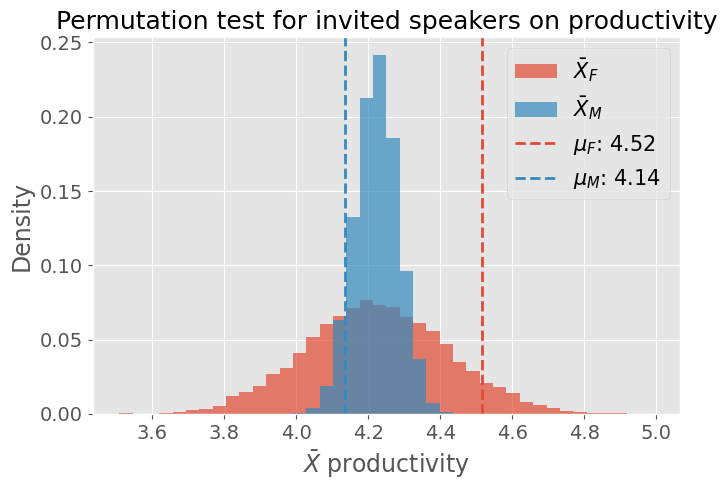

In [38]:
Permutation_plot_F_M(avg_F,True_avg_F,avg_M,True_avg_M, 'productivity', 'invited', 5, 7,'Permu_prod_F_M.pdf')

In [39]:
p_test(avg_M,True_avg_M,'lower')

795
delta < True_delta


0.0795

## P-Value plot

100%|██████████| 20/20 [03:30<00:00, 10.51s/it]


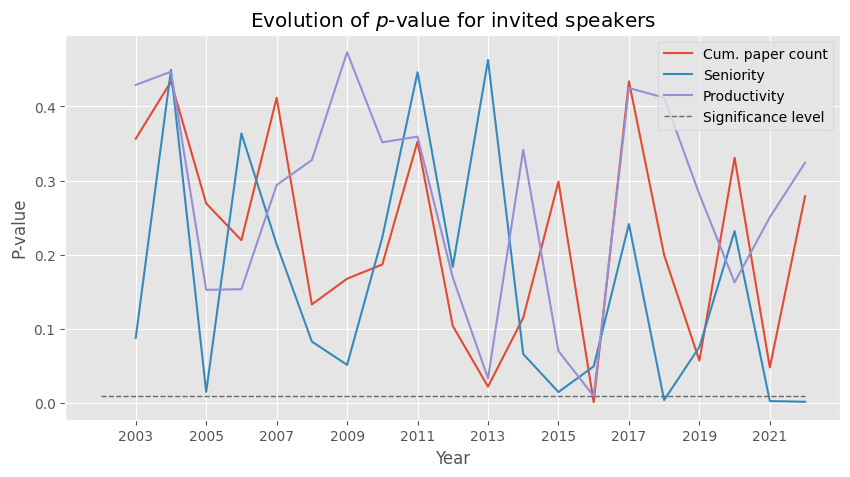

In [51]:
fig = plt.figure(figsize=(10,5))
column = ['Cum. paper count','Seniority','Productivity']
for col in column:
    P_value_list = []
    for year in tqdm(range(2003,2023)):
        df_year = df_Invited[df_Invited['Year'] == year]
        _, _, delta, _, _, True_delta = Permutation_test(df_year,10000,col)
        t_value = min(len([x for x in delta if x > True_delta]),len([x for x in delta if x < True_delta]))
        p_value = t_value / len(delta)
        P_value_list.append(p_value)
    plt.plot(range(2003,2023),P_value_list,label=col)
plt.xlabel('Year')
plt.ylabel('P-value')
plt.title('Evolution of $p$-value for invited speakers')
plt.xticks(range(2003,2023,2))
plt.hlines(y=0.01,xmin=2002,xmax=2022, color='dimgrey', linestyle='--',linewidth=1, label='Significance level')
plt.legend(loc='upper right')
plt.savefig(image_path+'p-value.pdf',bbox_inches='tight')
plt.show()